# Predição de uma Série Temporal

O Dataset do Kaggle utilizado para o desenvolvimento da atividade é o Microsoft Stock, disponível no Link: https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis?resource=download

In [21]:
# Importações

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# DATASET

In [22]:
# Carregar Dataset
df = pd.read_csv("Microsoft_Stock.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Primeiras linhas
print("Primeiras linhas do dataset:")
print(df.head())

# Informações gerais
print("\nInformações gerais:")
print(df.info())

# Estatística descritiva
print("\nEstatísticas descritivas:")
print(df.describe())

Primeiras linhas do dataset:
                 Date   Open   High    Low  Close    Volume
0 2015-04-01 16:00:00  40.60  40.76  40.31  40.72  36865322
1 2015-04-02 16:00:00  40.66  40.74  40.12  40.29  37487476
2 2015-04-06 16:00:00  40.34  41.78  40.18  41.55  39223692
3 2015-04-07 16:00:00  41.61  41.91  41.31  41.53  28809375
4 2015-04-08 16:00:00  41.48  41.69  41.04  41.42  24753438

Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Open    1511 non-null   float64       
 2   High    1511 non-null   float64       
 3   Low     1511 non-null   float64       
 4   Close   1511 non-null   float64       
 5   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 71.0 KB
None

Estatísticas descritivas:
                              

# ANÁLISE EXPLORATÓRIA

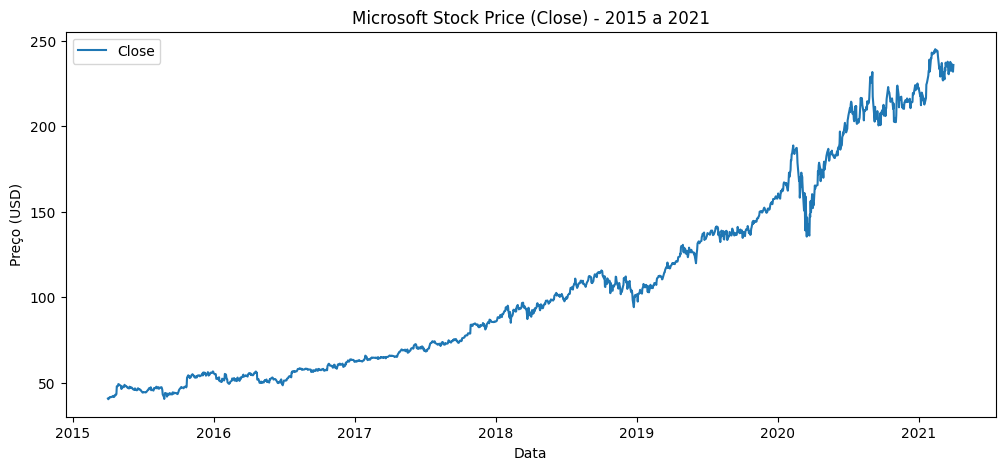

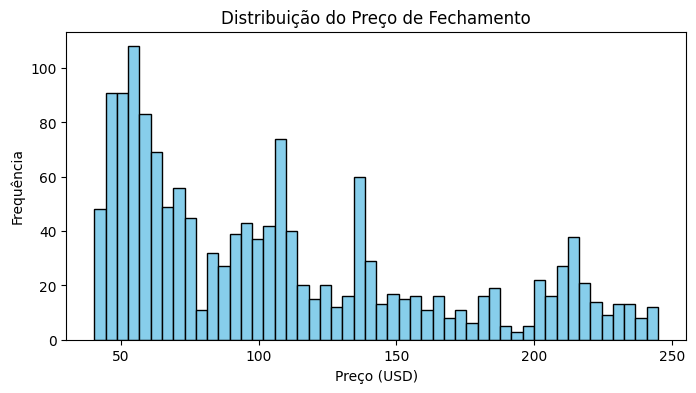

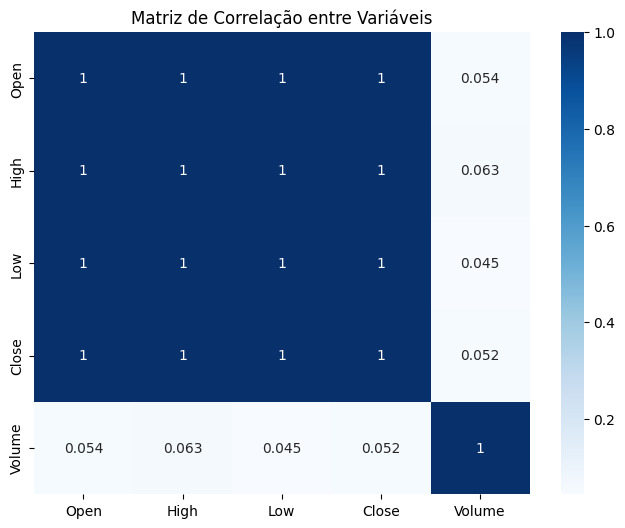

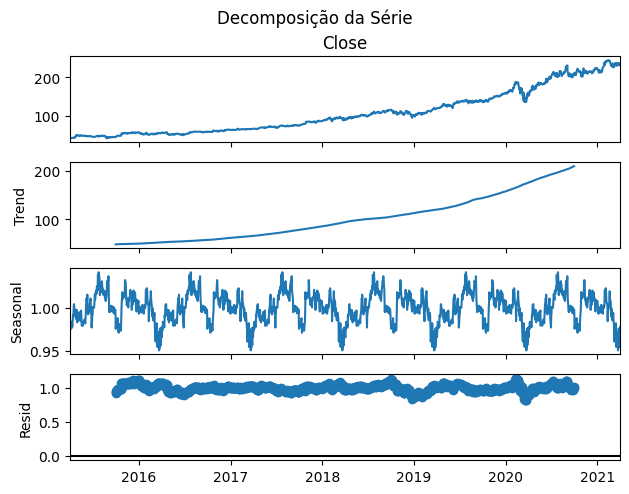

In [23]:
# Plotagem do preço de fechamento
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"], label="Close")
plt.title("Microsoft Stock Price (Close) - 2015 a 2021")
plt.xlabel("Data")
plt.ylabel("Preço (USD)")
plt.legend()
plt.show()

# Histograma do preço de fechamento
plt.figure(figsize=(8,4))
plt.hist(df["Close"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribuição do Preço de Fechamento")
plt.xlabel("Preço (USD)")
plt.ylabel("Frequência")
plt.show()

# Matriz de correlação
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns=["Date"]).corr(), annot=True, cmap="Blues")
plt.title("Matriz de Correlação entre Variáveis")
plt.show()

# Decomposição da série
result = seasonal_decompose(df.set_index("Date")["Close"], model="multiplicative", period=252)
# 252 = número médio de dias úteis em um ano
result.plot()
plt.suptitle("Decomposição da Série", y=1.02)
plt.show()

# MODELO PROPHET

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvspncoup/vib1898o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvspncoup/hp41tpz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38075', 'data', 'file=/tmp/tmpvspncoup/vib1898o.json', 'init=/tmp/tmpvspncoup/hp41tpz_.json', 'output', 'file=/tmp/tmpvspncoup/prophet_model22e5own2/prophet_model-20251002122711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:27:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Métricas de erro (Prophet):
RMSE: 14.66
MAE:  11.89
MAPE: 6.37%


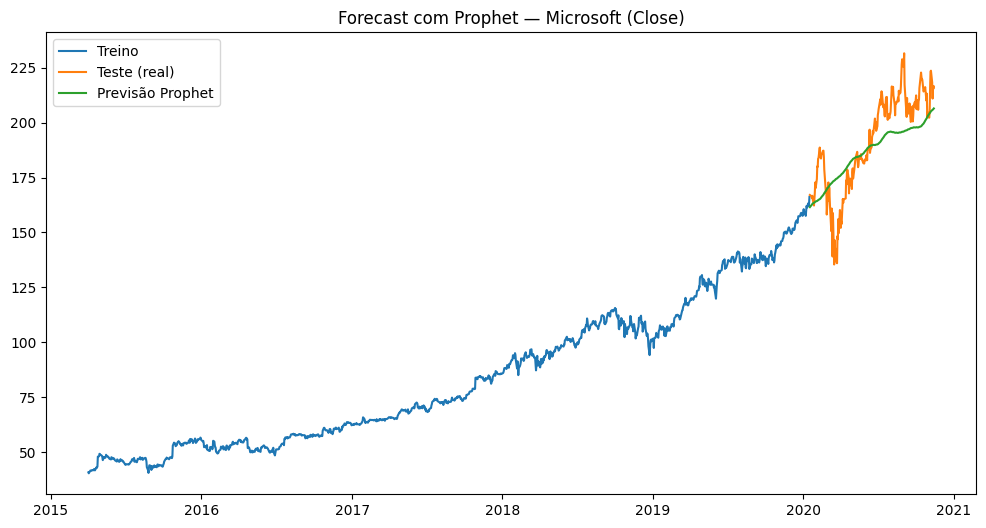

In [24]:
"""
    Treina e avalia um modelo Prophet para previsão de séries temporais.

    Este procedimento realiza:
      1. Preparação dos dados no formato exigido pelo Prophet (colunas `ds` e `y`).
      2. Divisão dos dados em conjunto de treino (80%) e teste (20%).
      3. Treinamento do modelo Prophet com sazonalidade diária ativada.
      4. Geração de previsões para o período de teste.
      5. Alinhamento das previsões com os valores reais.
      6. Cálculo de métricas de erro: RMSE, MAE e MAPE.
      7. Visualização gráfica comparando treino, teste real e previsões.

    """

# Preparar dados para Prophet
data = df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})

# split 80% treino / 20% teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Treinar modelo Prophet
model = Prophet(daily_seasonality=True)
model.fit(train)

# previsões para o período de teste
future = model.make_future_dataframe(periods=len(test), freq="D")
forecast = model.predict(future)

# Alinhar previsões e valores reais
pred = forecast[["ds", "yhat"]]
merged = pd.merge(test, pred, on="ds", how="left")

# remover NaNs (datas que não tinham previsão válida)
mask = ~merged["yhat"].isna()
merged = merged[mask]

y_true = merged["y"].values
y_pred = merged["yhat"].values

# Métricas de erro
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nMétricas de erro (Prophet):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


# Plotar previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Treino")
plt.plot(merged["ds"], y_true, label="Teste (real)")
plt.plot(merged["ds"], y_pred, label="Previsão Prophet")
plt.legend()
plt.title("Forecast com Prophet — Microsoft (Close)")
plt.show()


# MODELO LSTM

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0207 - val_loss: 0.0024
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2.7403e-04 - val_loss: 0.0018
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 1.4812e-04 - val_loss: 0.0018
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.4328e-04 - val_loss: 0.0019
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.4101e-04 - val_loss: 0.0018
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.1829e-04 - val_loss: 0.0018
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.2574e-04 - val_loss: 0.0018
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.1777e-04 - val_loss: 0.0017
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 1.2307e-04 - val_loss: 0.0018
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.3275e-04 - val_loss: 0.0017
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 1.2567e-04 - val_loss: 0.0017
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━

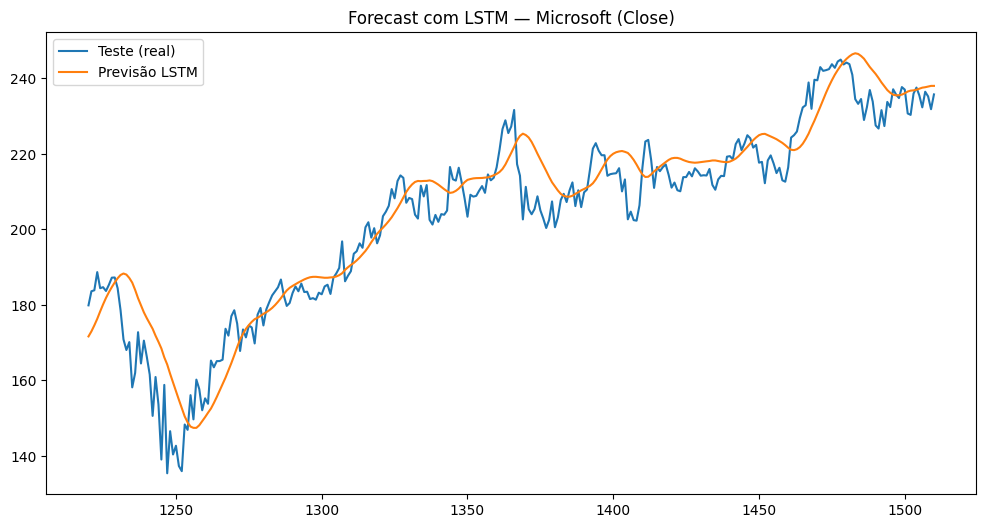

In [25]:
"""
    Treina e avalia um modelo LSTM para previsão de séries temporais financeiras.

    Este procedimento realiza:
      1. Seleção da variável alvo (preço de fechamento).
      2. Normalização dos dados para o intervalo [0, 1].
      3. Criação de janelas de tempo (sequências) para entrada no modelo.
      4. Separação em conjuntos de treino (80%) e teste (20%).
      5. Construção e treinamento de uma rede neural LSTM.
      6. Desnormalização das previsões para valores reais.
      7. Cálculo de métricas de erro: RMSE, MAE e MAPE.
      8. Plotagem da previsão comparada aos valores reais.

    """

# Apenas o preço de fechamento
data = df[["Date", "Close"]].set_index("Date")


# Normalização
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data)


# Função para criar janelas de tempo
def create_sequences(dataset, window_size=60):
    X, y = [], []
    for i in range(len(dataset)-window_size):
        X.append(dataset[i:i+window_size, 0])
        y.append(dataset[i+window_size, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled, window_size)

# reshape para [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


# Split treino / teste (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


# Previsão
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))


# Métricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nMétricas de erro (LSTM):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


# Plotagem do gráfico
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_true):], y_true, label="Teste (real)")
plt.plot(df.index[-len(y_pred):], y_pred, label="Previsão LSTM")
plt.legend()
plt.title("Forecast com LSTM — Microsoft (Close)")
plt.show()


# Justificativa da escolha da métrica

- **RMSE (Root Mean Squared Error)**: mede a raiz do erro quadrático médio, dando maior peso a grandes desvios. É amplamente utilizado em regressão e previsão de séries temporais por destacar erros relevantes que podem impactar aplicações financeiras (Olumide, 2023).

- **MAE (Mean Absolute Error):** calcula o erro médio absoluto entre valores previstos e reais. Por estar na mesma escala da variável alvo, sua interpretação é direta e prática, representando o erro médio esperado em cada previsão (Ahmed, 2023).

- **MAPE (Mean Absolute Percentage Error)**: expressa o erro em termos percentuais, o que facilita a comparação entre diferentes ativos ou séries, independentemente da escala dos dados (Roberts, 2023).

**Justificativa da escolha:**

&emsp;As três métricas foram selecionadas de forma complementar, equilibrando:

- Interpretação prática: MAE e MAPE permitem comunicar os erros de maneira intuitiva, em termos absolutos e percentuais.

- Sensibilidade a grandes desvios: o RMSE penaliza erros elevados, o que é particularmente relevante em cenários financeiros, nos quais picos de erro podem representar perdas significativas.

## Referências

Olumide, S. **Erro Quadrático Médio (RMSE) em IA: O que você precisa saber**. 2023. Dísponível em: https://arize.com/blog-course/root-mean-square-error-rmse-what-you-need-to-know/.

Ahmed, M. **Compreendendo o erro médio absoluto (MAE) na regressão: um guia prático**. 2023. Disponível em: https://medium.com/@m.waqar.ahmed/understanding-mean-absolute-error-mae-in-regression-a-practical-guide-26e80ebb97df.

Roberts, A. **Erro Percentual Médio Absoluto (MAPE): O que você precisa saber**. 2023. Disponível em: https://arize.com/blog-course/mean-absolute-percentage-error-mape-what-you-need-to-know/.

# Resultados

- O LSTM superou o Prophet em todas as métricas, apresentando menor erro absoluto e percentual.

- O MAPE do LSTM (3.33%) indica que, em média, os erros de previsão ficaram próximos de 3% do valor real, o que é considerado um bom resultado em séries financeiras.

- O RMSE foi escolhido como principal métrica de comparação, pois penaliza mais fortemente grandes erros — característica importante em finanças, onde desvios grandes podem impactar significativamente as decisões
